In [2]:
import torch, os, PIL, pdb, torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import time
import sys

# Import WGAN Generator & Critic Model-Architecture Definition Modules
sys.path.append("./WGAN")

from WGAN.Generator import Generator
from WGAN.Critic import Critic

In [3]:
def load_checkpoint(epoch_number, device, learning_rate=1e-4):
    """
        Load the stored WGAN Generator & Critic Models from the checkpoints. 
    """
    chkpt_path_name = './models/Generator_{}.pth'.format(epoch_number)
    checkpoint = torch.load(chkpt_path_name)
    
    generator_model = Generator().to(device)
    generator_optimizer = torch.optim.Adam( generator_model.parameters(),
                                            lr=learning_rate, betas=(0.5,0.9)
                                          )
    
    generator_model.load_state_dict(checkpoint['generator_model_state_dict'])
    generator_optimizer.load_state_dict(checkpoint['generator_optimizer_state_dict'])    
    

    chkpt_path_name = './models/Critic_{}.pth'.format(epoch_number)
    checkpoint = torch.load(chkpt_path_name)
    
    critic_model = Critic().to(device)
    critic_optimizer = torch.optim.Adam( critic_model.parameters(),
                                         lr=learning_rate, betas=(0.5,0.9)
                                       )
    
    critic_model.load_state_dict(checkpoint['critic_model_state_dict'])
    critic_optimizer.load_state_dict(checkpoint['critic_optimizer_state_dict'])
    
    print('Successfully loaded Checkpoint!')
    
    return ( generator_model, generator_optimizer, 
             critic_model, critic_optimizer
           )

In [4]:
def peek_tensor(data_tensor, sample_size=16, name=''):
    """
        Take a peek at a sample of the dataset.
    """
    # Detach the Data Tensor & put to CPU
    data = data_tensor.detach().cpu()
    
    # To obtain grid view - permute tensor to get channel dim at the end with the
    # 'height' & 'width' of image at the beginning
    grid_view = make_grid(data[:sample_size], nrow= 4).permute(1,2,0)

    plt.imshow(grid_view.clip(0, 1))
    plt.show()

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else "cpu:0"
gen_model, gen_optimizer, critic_model, critic_optimizer = load_checkpoint(4, device, learning_rate=1e-4)

gen_model

Successfully loaded Checkpoint!


Generator(
  (generator_model): Sequential(
    (0): ConvTranspose2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_r

In [27]:
# create a Noisy tensor with the dimensions of the image we want to generate
noise_tensor = torch.randn(16, 256, device=device)

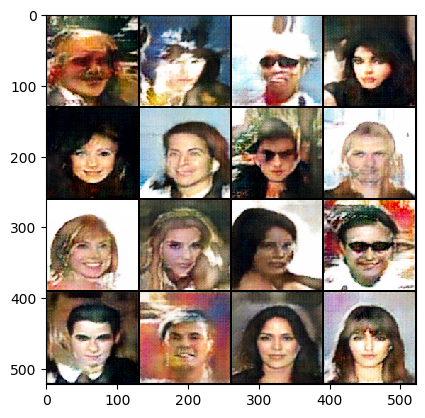

In [28]:
generated_fake_faces_tensor = gen_model(noise_tensor)

# Visualize the generated images of non-existent individuals
peek_tensor(generated_fake_faces_tensor, sample_size=16)

<h4>The WGAN generator converted a Tensor of pure Random noise into a human face !</h4>

The images generated are of <em>128 pixel X 128 pixel</em> ~ which is pretty much of low-resolution. However, the <em><u>distinct features</u></em> of the Human face can be clearly identified from the reproduced images.

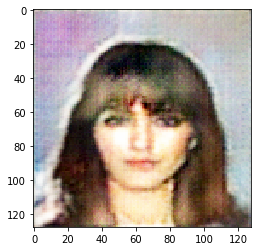

In [35]:
%matplotlib inline

plt.imshow(generated_fake_faces_tensor[-1].detach().cpu().permute(1,2,0).clip(0,1))

<h3>Morphing Between points in the Latent-Space Representation of the WGAN</h3>

Each point in the Latent-Space constitutes learnt representations of the WGAN which would correspond to a distinct reproduction of the learnt features i.e. since in this project the <b>WGAN</b> was trained on Human Faces, each point in the Latent Space would be a combination of features which correspond to a learnt representation of a distinct human face.

In [29]:
# populate the generated images as we interpolate between the features of two points in Latent Space
interpolation_feature_set = []
interpolation_latent_dims = [1, 256, 1, 1]

# number of different points to interpolate from.
n_rows = 5

# Morphing or transformation between one point in the latent space to another point will be done in 'n_steps' steps
n_steps = 20

In [30]:
# Initiate the Interpolation

for i in range(n_rows):
    # select two points in the latent space to perform the interpolation i.e. random points in Latent Space
    latent_point1, latent_point2 = torch.randn(interpolation_latent_dims), torch.randn(interpolation_latent_dims)
    
    # get 'n_steps' number of values between the range [0, 1] to perform interpolation
    for latent_factor in np.linspace(0, 1, n_steps):
        latent_point = latent_factor*latent_point1 + (1 - latent_factor)*latent_point2
        
        # Generate image from the interpolated Latent Vector with Trained Generator Model
        gen_data_tensor = gen_model( latent_point.cuda() )[0]
        
        # Collate & store the Generated Image Tensor from the Interpolation Result
        interpolation_feature_set.append( gen_data_tensor )

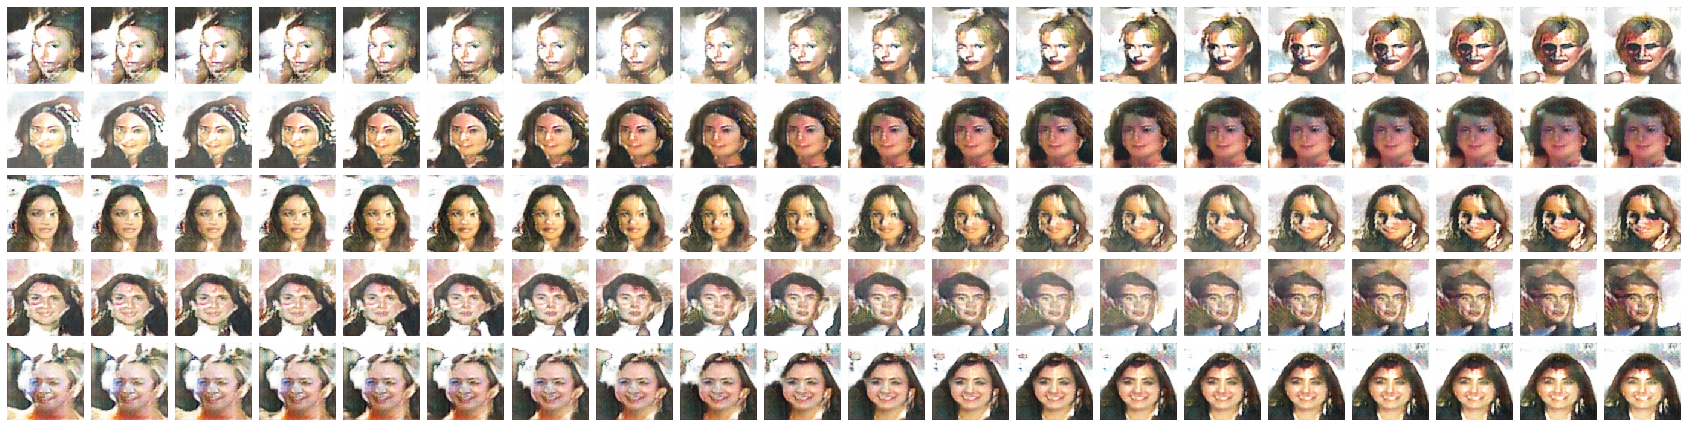

In [22]:
%matplotlib inline

fig = plt.figure(figsize=(30, 20))

# Instantiate an ImageGrid object with identical dimensions as of the number of Interpolated Images
img_grid = ImageGrid( fig, 111, nrows_ncols=(n_rows, n_steps), axes_pad=0.1 )

for ax, img in zip(img_grid, interpolation_feature_set):
    
    ax.axis('off') # No marks along the axis
    
    # Convert Tensor to appropriate format for displaying : 'height' X 'width' X 'channels'
    resultant_img = img.cpu().detach().permute(1, 2, 0)
    
    # Remove any Negative Values
    resultant_img -= resultant_img.min()
    
    # Normalize the Pixels of the Resultant Interpolated Imge
    resultant_img = resultant_img/(resultant_img.max() - resultant_img.min())
    
    ax.imshow(resultant_img)

plt.show()